In [1]:
import os
import sys
from pathlib import Path
import torchvision
from matplotlib import pyplot as plt

sys.path.append("../")

from utils.dataloader import Vectorize_WSIs

parent_path = Path("/localscratch")
imgs_path = parent_path / Path([p for p in os.listdir(parent_path) if "ramanav" in p ][0]) / "SSL_training"

dataset = Vectorize_WSIs(
                        image_pth=str(imgs_path / "images/122S.tif"),
                        mask_pth=str(imgs_path / "masks"),
                        template_pth=str(imgs_path.parent/"by_class"),
                        tile_h=256,
                        tile_w=256,
                        tile_stride_factor_h=3,
                        tile_stride_factor_w=3,
                        colors=[("black","#28282B"),("#002d04","#2a7e19"),("#000133","skyblue"),("#1f0954","#6d5caf"),("#a90308","#ff000d")],
                        transform=torchvision.transforms.ToTensor()
)

Loading wsis.. 1/1: : 1it [00:22, 22.43s/it]


Loading the data...


100%|██████████| 10000/10000 [00:05<00:00, 1895.92it/s]


### Pairwise patch extraction

In [1]:
import os
import sys
sys.path.append("/home/ramanav/Projects/Ink-WSI")

import torch
import numpy as np
from pathlib import Path
import torchvision
from matplotlib import pyplot as plt

from modules.deploy import Pairwise_ExtractPatches

# INPUT_FILE = "/labs3/amartel_data3/histology/Data/DCIS_cohort/PRECISE_NoRT/114793.svs"
# INPUT_FILE = "/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121504.svs"
# INPUT_FILE = "/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121504.svs"
DEST_FILE = "/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121504.svs"
SRC_FILE = "/labs3/amartel_data3/histology/Data/DCIS_cohort/PRECISE_NoRT/114793.svs"

# OUTPUT_DIR = "/home/ramanav/Projects/Ink-WSI/tests/Results/Ink_121393"

# if not Path(OUTPUT_DIR).exists():
#     os.mkdir(OUTPUT_DIR)

TILE_H = 256
TILE_W = 256
TILE_STRIDE_FACTOR_H = 1
TILE_STRIDE_FACTOR_W = 1
LWST_LEVEL_IDX = 0
TRANSFORM = torchvision.transforms.ToTensor()
# SPACING = 0.2526
SPACING = None


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


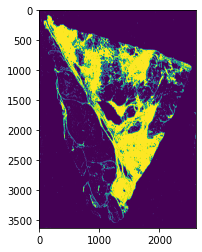

In [47]:
sys.path.append("/amartel_data4/temp/lukasz_test/blur/")

from dptools.slides.processing.wsimask import WSIMask

tissue_mask = WSIMask("/labs3/amartel_data3/histology/Data/DCIS_cohort/PRECISE_NoRT/114793.svs", min_size=500, mode="lab", threshold=0.1)
plt.imshow(tissue_mask.array)

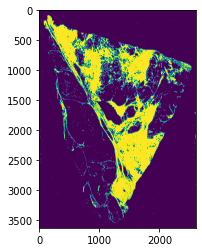

In [50]:
tissue_mask = WSIMask("/labs3/amartel_data3/histology/Data/DCIS_cohort/PRECISE_NoRT/114793.svs", min_size=500, mode="lab", threshold=0.4)
plt.imshow(tissue_mask.array)

In [2]:
dataset = Pairwise_ExtractPatches(
        pair_pths=(SRC_FILE,DEST_FILE),
        tile_h=TILE_H,
        tile_w=TILE_W,
        tile_stride_factor_h=TILE_STRIDE_FACTOR_H,
        tile_stride_factor_w=TILE_STRIDE_FACTOR_W,
        spacing=None,
        lwst_level_idx=LWST_LEVEL_IDX,
        mode="train",
        train_split=1,
        transform=TRANSFORM,
        threshold=0.7
)

Loading wsis.. 1/1: : 1it [13:45, 825.04s/it]


ssim: 0.13180826672687881
psnr: 9.716661359489088
vif: [7.32247096 6.82243916]


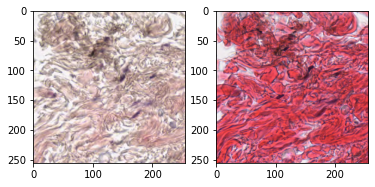

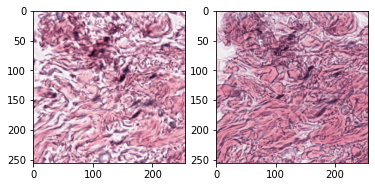

ssim with norm: 0.12825268202139725
psnr with norm: 12.72056827276218
vif with norm: [7.16145759 7.15407513]
Mean Absolute error, pixel_wise: 292.552734375
Mean Absolute error normalized, pixel_wise: 312.8055877685547


In [38]:
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import variation_of_information as vif
import cv2
import staintools

idx = 0
ink_patch, reg_patch = dataset.all_image_tiles_hr[idx]

fig,axes = plt.subplots(1,2)
axes[0].imshow(ink_patch)
axes[1].imshow(reg_patch)

data_range = reg_patch.max() - reg_patch.min()
ssim_without_normalization = ssim(ink_patch, reg_patch, data_range=data_range, channel_axis=-1, multichannel=True)
psnr_without_normalization = psnr(ink_patch, reg_patch, data_range=data_range)
vif_without_normalization = vif(ink_patch, reg_patch)

print("ssim: {}\npsnr: {}\nvif: {}".format(ssim_without_normalization,psnr_without_normalization,vif_without_normalization))

#With normalization
#Color Normalization

template_img = cv2.cvtColor(cv2.imread("/home/ramanav/Projects/Ink-WSI/modules/register/staintemplate.png"),cv2.COLOR_BGR2RGB)
normalizer = staintools.StainNormalizer(method="vahadane")
normalizer.fit(template_img)

ink_patch, reg_patch = dataset.all_image_tiles_hr[idx]
normalize_ink = normalizer.transform(ink_patch)
normalize_reg = normalizer.transform(reg_patch)

fig,axes = plt.subplots(1,2)
axes[0].imshow(normalize_ink)
axes[1].imshow(normalize_reg)
plt.show()

data_range = normalize_reg.max() - normalize_reg.min()
ssim_with_normalization = ssim(normalize_ink, normalize_reg, data_range=data_range, channel_axis=-1, multichannel=True)
psnr_with_normalization = psnr(normalize_ink, normalize_reg, data_range=data_range)
vif_with_normalization = vif(normalize_ink, normalize_reg)

print("ssim with norm: {}\npsnr with norm: {}\nvif with norm: {}".format(ssim_with_normalization,psnr_with_normalization,vif_with_normalization))

print("Mean Absolute error, pixel_wise: {}".format(np.sum(np.abs(ink_patch-reg_patch))*1.0/(256*256)))
print("Mean Absolute error normalized, pixel_wise: {}".format(np.sum(np.abs(normalize_ink-normalize_reg))*1.0/(256*256)))


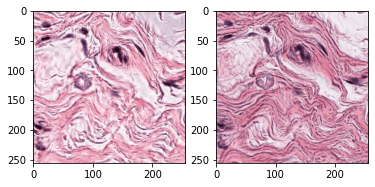

ssim: 0.12180643017731696
psnr: 13.849930046811927
vif: [7.02707666 6.8045718 ]


In [29]:
#With normalization
#Color Normalization

template_img = cv2.cvtColor(cv2.imread("/home/ramanav/Projects/Ink-WSI/modules/register/staintemplate.png"),cv2.COLOR_BGR2RGB)
normalizer = staintools.StainNormalizer(method="vahadane")
normalizer.fit(template_img)

ink_patch, reg_patch = dataset.all_image_tiles_hr[idx]
normalize_ink = normalizer.transform(ink_patch)
normalize_reg = normalizer.transform(reg_patch)

fig,axes = plt.subplots(1,2)
axes[0].imshow(normalize_ink)
axes[1].imshow(normalize_reg)
plt.show()

ssim_with_normalization = ssim(normalize_ink, normalize_reg, data_range=255, channel_axis=-1, multichannel=True)
psnr_with_normalization = psnr(normalize_ink, normalize_reg, data_range=255)
vif_with_normalization = vif(normalize_ink, normalize_reg)

print("ssim with norm: {}\npsnr with norm: {}\nvif with norm: {}".format(ssim_with_normalization,psnr_with_normalization,vif_with_normalization))

ssim: 0.4784196715999043
psnr: 16.241075233659803
vif: 0.11907172386794627


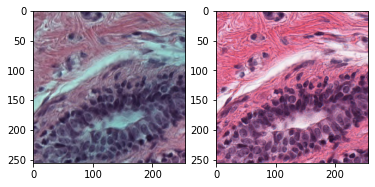

In [12]:
from quality_metrics import ssim, psnr, mse, pbvif

idx = 2000
ink_patch, reg_patch = dataset.all_image_tiles_hr[idx]

fig,axes = plt.subplots(1,2)
axes[0].imshow(ink_patch)
axes[1].imshow(reg_patch)

data_range = ink_patch.max() - ink_patch.min()
ssim_without_normalization = ssim( reg_patch,ink_patch)
psnr_without_normalization = psnr(reg_patch, ink_patch)
vif_without_normalization = pbvif(reg_patch, ink_patch)

print("ssim: {}\npsnr: {}\nvif: {}".format(ssim_without_normalization,psnr_without_normalization,vif_without_normalization))

# template_img = cv2.cvtColor(cv2.imread("/home/ramanav/Projects/Ink-WSI/modules/register/staintemplate.png"),cv2.COLOR_BGR2RGB)
# normalizer = staintools.StainNormalizer(method="vahadane")
# normalizer.fit(template_img)

# ink_patch, reg_patch = dataset.all_image_tiles_hr[idx]
# normalize_ink = normalizer.transform(ink_patch)
# normalize_reg = normalizer.transform(reg_patch)

# fig,axes = plt.subplots(1,2)
# axes[0].imshow(normalize_ink)
# axes[1].imshow(normalize_reg)
# plt.show()

# ssim_with_normalization = ssim( normalize_reg, normalize_ink)
# psnr_with_normalization = psnr(normalize_reg, normalize_ink)
# vif_with_normalization = pbvif(normalize_reg,normalize_ink)

# print("ssim with norm: {}\npsnr with norm: {}\nvif with norm: {}".format(ssim_with_normalization,psnr_with_normalization,vif_with_normalization))

In [20]:
SSIM = []
for i in range(len(dataset)):
    ink_patch, src_patch = dataset[i]
    ink_patch = np.asarray(ink_patch.permute(1,2,0).numpy()*255,np.uint8)
    src_patch = np.asarray(src_patch.permute(1,2,0).numpy()*255,np.uint8)
    SSIM.append(ssim(src_patch,ink_patch))


In [22]:
SSIM = np.array(SSIM)

In [23]:
np.where(SSIM<0.3)

(array([   7,    8,    9, ..., 9121, 9122, 9123]),)

ssim: 0.054118864215774797
psnr: 5.529380411246015
vif: 0.5285671938649738


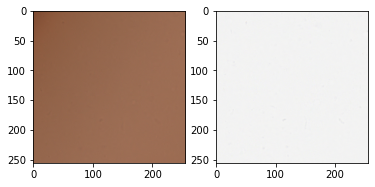

In [46]:
low_ssim_idx = np.where(SSIM<=0.25)[0]
idx = low_ssim_idx[30]
ink_patch, reg_patch = dataset.all_image_tiles_hr[idx]

fig,axes = plt.subplots(1,2)
axes[0].imshow(ink_patch)
axes[1].imshow(reg_patch)

data_range = ink_patch.max() - ink_patch.min()
ssim_without_normalization = ssim( reg_patch,ink_patch)
psnr_without_normalization = psnr(reg_patch, ink_patch)
vif_without_normalization = pbvif(reg_patch, ink_patch)

print("ssim: {}\npsnr: {}\nvif: {}".format(ssim_without_normalization,psnr_without_normalization,vif_without_normalization))

/home/ramanav/anaconda3/envs/tiger2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

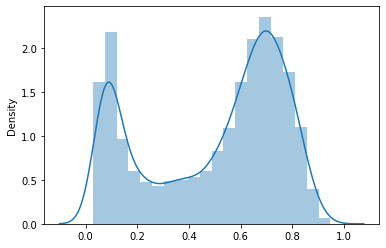

In [21]:
import seaborn as sns
sns.distplot(SSIM)

In [15]:
ink_patch

array([[[160., 144., 166.],
        [143., 129., 148.],
        [162., 149., 164.],
        ...,
        [101.,  88., 116.],
        [ 97.,  84., 114.],
        [ 94.,  81., 112.]],

       [[154., 137., 159.],
        [134., 118., 138.],
        [137., 121., 138.],
        ...,
        [110.,  98., 123.],
        [110.,  98., 121.],
        [106.,  94., 116.]],

       [[146., 127., 149.],
        [140., 121., 141.],
        [138., 119., 136.],
        ...,
        [119., 109., 129.],
        [123., 112., 130.],
        [120., 109., 123.]],

       ...,

       [[139., 123., 150.],
        [133., 117., 145.],
        [113.,  98., 127.],
        ...,
        [114.,  77., 117.],
        [109.,  73., 114.],
        [112.,  76., 118.]],

       [[132., 121., 146.],
        [131., 119., 145.],
        [105.,  93., 121.],
        ...,
        [128.,  87., 127.],
        [124.,  82., 123.],
        [132.,  91., 131.]],

       [[134., 127., 151.],
        [140., 132., 156.],
        [126., 1

In [4]:
import sys
sys.path.append("../")
from modules.deploy import ExtractPatches
from matplotlib import pyplot as plt

In [ ]:
image_pth = "/labs3/amartel_data3/tiger_dataset/tiger-training-data/wsitils/images/104S.tif"
mask_pth = "/labs3/amartel_data3/tiger_dataset/tiger-training-data/wsitils/tissue-masks"
dataset = ExtractPatches(
        image_pth=image_pth,
        tile_h=256,
        tile_w=256,
        tile_stride_factor_h=1,
        tile_stride_factor_w=1,
        spacing=None,
        mask_pth=mask_pth,
        lwst_level_idx=0,
        mode="train",
        train_split=1,
        transform=None,
        threshold=0.95
)

In [2]:
len(dataset)

23606

In [5]:
image_pth = "/labs3/amartel_data3/histology/Data/DCIS_cohort/PRECISE_NoRT/114758.svs"
dataset = ExtractPatches(
        image_pth=image_pth,
        tile_h=256,
        tile_w=256,
        tile_stride_factor_h=7,
        tile_stride_factor_w=7,
        spacing=None,
        output_pth="/home/ramanav/Projects/Ink-WSI/tests/Results",
        lwst_level_idx=0,
        mode="train",
        train_split=1,
        transform=None,
        threshold=0.95
)

Loading wsis.. 1/1: : 1it [14:28, 868.34s/it]


In [6]:
len(dataset)

76

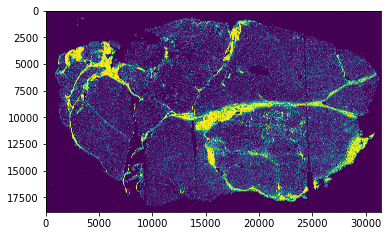

In [8]:
plt.imshow(plt.imread("/home/ramanav/Projects/Ink-WSI/tests/Results/mask_image.png"))

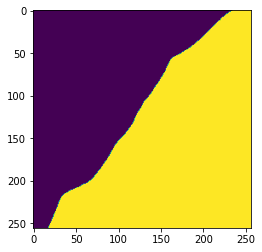

In [5]:
from matplotlib import pyplot as plt
plt.imshow(dataset.mask_slide.read_region((2957,3126), 0, (256,256)).convert("L"))

In [2]:
len(dataset)

23606

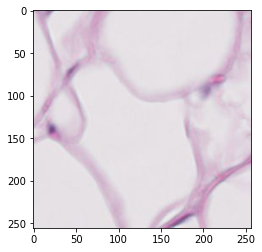

In [12]:
from matplotlib import pyplot as plt
plt.imshow(dataset[2531])

In [1]:
from pathlib import Path
mask_pth = "/labs3/amartel_data3/tiger_dataset/tiger-training-data/wsitils/tissue-masks"
list(Path(mask_pth).glob("*"))

[PosixPath('/labs3/amartel_data3/tiger_dataset/tiger-training-data/wsitils/tissue-masks/104S_tissue.tif'),
 PosixPath('/labs3/amartel_data3/tiger_dataset/tiger-training-data/wsitils/tissue-masks/105S_tissue.tif'),
 PosixPath('/labs3/amartel_data3/tiger_dataset/tiger-training-data/wsitils/tissue-masks/106S_tissue.tif'),
 PosixPath('/labs3/amartel_data3/tiger_dataset/tiger-training-data/wsitils/tissue-masks/107S_tissue.tif'),
 PosixPath('/labs3/amartel_data3/tiger_dataset/tiger-training-data/wsitils/tissue-masks/108S_tissue.tif'),
 PosixPath('/labs3/amartel_data3/tiger_dataset/tiger-training-data/wsitils/tissue-masks/110S_tissue.tif'),
 PosixPath('/labs3/amartel_data3/tiger_dataset/tiger-training-data/wsitils/tissue-masks/112B_tissue.tif'),
 PosixPath('/labs3/amartel_data3/tiger_dataset/tiger-training-data/wsitils/tissue-masks/121S_tissue.tif'),
 PosixPath('/labs3/amartel_data3/tiger_dataset/tiger-training-data/wsitils/tissue-masks/123S_tissue.tif'),
 PosixPath('/labs3/amartel_data3/tige

In [3]:
list(filter(lambda x: "104S" in str(x),list(Path(mask_pth).glob("*"))))

[PosixPath('/labs3/amartel_data3/tiger_dataset/tiger-training-data/wsitils/tissue-masks/104S_tissue.tif')]

In [3]:
master_path = list(Path("/localscratch/ramanav.38626443.0/by_class").glob("**/*.png"))

In [7]:
len(master_path)

1545923

In [2]:
dataset.ink_templates[0]

In [2]:
all_imgs = dataset.all_image_tiles_hr

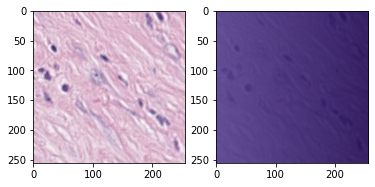

In [14]:
idx = 1
fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(all_imgs[idx])
plt.subplot(1,2,2)
plt.imshow(dataset[idx][0].permute(1,2,0))

In [3]:
import trainer
import sys
sys.path.append("../")
import utils
from pathlib import Path

parent_path = Path("/localscratch")
imgs_path = parent_path / Path([p for p in os.listdir(parent_path) if "ramanav" in p ][0]) / "SSL_training"

dataset = trainer.Dataset.create("ink",
                                 path=str(imgs_path),
                                 test_batch_size=64,
                                 train_batch_size=64,
                                image_pth=str(imgs_path / "images/122S.tif"),
                                mask_pth=str(imgs_path / "masks"),
                                template_pth=str(imgs_path.parent/"by_class"),
                                tile_h=256,
                                tile_w=256,
                                tile_stride_factor_h=3,
                                tile_stride_factor_w=3,
                                colors=[("black","#28282B"),("#002d04","#2a7e19"),("#000133","skyblue"),("#1f0954","#6d5caf"),("#a90308","#ff000d")],
                                train_split=0.8
)

Loading wsis.. 1/1: : 1it [00:16, 16.93s/it]


Loading the data...


100%|██████████| 10000/10000 [00:03<00:00, 2544.08it/s]
Loading wsis.. 1/1: : 1it [00:16, 16.05s/it]


Loading the data...


100%|██████████| 10000/10000 [00:03<00:00, 2590.36it/s]
/home/ramanav/projects/rrg-amartel/ramanav/Projects/InkFilter/ink/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
from tqdm import tqdm
for img,label in tqdm(dataset.train_loader):
    pass

100%|██████████| 42/42 [00:52<00:00,  1.24s/it]


In [4]:
dataset.trainset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 1)

In [15]:
dataset.ink_generator.get_plots(all_imgs[56])

TypeError: unsupported operand type(s) for /: 'int' and 'builtin_function_or_method'

<Figure size 720x720 with 0 Axes>

In [5]:
dataset[idx]

(tensor([[[0.8431, 0.8588, 0.8784,  ..., 0.9176, 0.9333, 0.9529],
          [0.8118, 0.8314, 0.8627,  ..., 0.9137, 0.9333, 0.9490],
          [0.7804, 0.8000, 0.8314,  ..., 0.9059, 0.9176, 0.9333],
          ...,
          [0.9176, 0.8784, 0.8471,  ..., 0.8431, 0.8431, 0.8510],
          [0.9294, 0.8941, 0.8706,  ..., 0.8667, 0.8431, 0.8353],
          [0.9294, 0.9059, 0.8824,  ..., 0.9020, 0.8824, 0.8706]],
 
         [[0.7333, 0.7451, 0.7608,  ..., 0.8275, 0.8510, 0.8706],
          [0.7020, 0.7176, 0.7451,  ..., 0.8235, 0.8431, 0.8667],
          [0.6824, 0.6902, 0.7216,  ..., 0.8078, 0.8275, 0.8431],
          ...,
          [0.7843, 0.7451, 0.7098,  ..., 0.7490, 0.7490, 0.7569],
          [0.7961, 0.7608, 0.7333,  ..., 0.7725, 0.7490, 0.7412],
          [0.8039, 0.7765, 0.7529,  ..., 0.8078, 0.7882, 0.7765]],
 
         [[0.8196, 0.8314, 0.8549,  ..., 0.8980, 0.9176, 0.9373],
          [0.7882, 0.8039, 0.8392,  ..., 0.8941, 0.9137, 0.9333],
          [0.7647, 0.7765, 0.8118,  ...,

In [18]:
dataset[15]

(tensor([[[0.7373, 0.7373, 0.7490,  ..., 0.8588, 0.8863, 0.9176],
          [0.7137, 0.7373, 0.7451,  ..., 0.8745, 0.8667, 0.8667],
          [0.6941, 0.7255, 0.7176,  ..., 0.8863, 0.8471, 0.8235],
          ...,
          [0.8392, 0.8157, 0.8078,  ..., 0.9255, 0.8745, 0.8235],
          [0.8235, 0.8039, 0.7961,  ..., 0.9176, 0.8824, 0.8431],
          [0.8078, 0.7882, 0.7882,  ..., 0.9333, 0.9176, 0.8980]],
 
         [[0.6078, 0.6078, 0.6078,  ..., 0.7255, 0.7333, 0.7647],
          [0.5843, 0.6078, 0.6039,  ..., 0.7373, 0.7137, 0.7137],
          [0.5647, 0.5961, 0.5765,  ..., 0.7451, 0.6941, 0.6706],
          ...,
          [0.6824, 0.6588, 0.6510,  ..., 0.7804, 0.7412, 0.6863],
          [0.6588, 0.6392, 0.6314,  ..., 0.7804, 0.7529, 0.7137],
          [0.6392, 0.6196, 0.6118,  ..., 0.8039, 0.8000, 0.7804]],
 
         [[0.7922, 0.7922, 0.7882,  ..., 0.8196, 0.8392, 0.8784],
          [0.7686, 0.7843, 0.7843,  ..., 0.8314, 0.8196, 0.8275],
          [0.7412, 0.7725, 0.7490,  ...,